# RibbID

## A machine learning model to identify anuran species through their calls

Restricted to Catalonian species (northern Spain)

The objective of this project is to create two machine learning models to identify frog and toad species through audio files. This end-to-end Jupyter notebook is composed of multiple parts:
- **Environment setup**: installing dependencies, setting random seeds, defining paths

- **Exploratory Data Analysis**: distribution of recordings by species, waveform and spectrogram visualizations

- **Baseline SVM model** on handcrafted features

- **Multi-label CNN model**: using log-Mel spectrograms, advanced preprocessing, data augmentation, transfer learning (EfficientNet-based), threshold calibration, and multi-label inference

- **Final evaluation**: classification reports, confusion matrices, ROC & PR curves) and example inference on new audio files

The anuran species that these models will be able to identify are the following 8 native catalan amphibian species, corresponding to 6 different families:

Alytidae

- *Alytes obstetricans*

Bufonidae

- *Bufo spinosus*
- *Epidalea calamita*

Hylidae

- *Hyla meridionalis*

Pelobatidae

- *Pelobates cultripes*

Pelodytidae

- *Pelodytes punctatus*

Ranidae

- *Pelophylax spp.* (multiple species for this genus)
- *Rana temporaria*



## 1. Environment setup

The first step is to import the libraries needed for the creation of the model. If any of the libraries is not installed on your environment, do it so by running, in the anaconda prompt, the following commands:
- conda activate RibbID
- pip install **library** *(modify this with the name of the desired library)*

In [1]:
import os, glob, random, sys, librosa, librosa.display, random, joblib, pprint, warnings, torch, pickle
import numpy as np
import seaborn as sns
import scipy.signal as sps
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sps

from IPython.display import Audio
from pydub import AudioSegment
from pathlib import Path

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torchvision.models import efficientnet_b0
from torchinfo import summary

Next, global parameters such as the seed and the device for the future CNN model are defined

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Following, the path setup, in which the paths are centralized so the whole notebook uses them consistently

In [3]:
BASE_DIR = Path.home() / "Desktop" / "RibbID"
AUDIO_DIR = BASE_DIR / "data" / "raw"
LABELS_PATH = BASE_DIR / "data" / "processed" / "labels.csv"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

And, finally, we set a particular display setting for the plots and a non-critical deprecation warnings silencer:

In [4]:
# Plot display settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-muted")

# Ignore general user warnings (e.g. torchvision deprecation)
warnings.filterwarnings("ignore", category=UserWarning)

# Ignore upcoming feature warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Ignore deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

> This notebook assumes that all required files and folders are located within a single directory called **`RibbID`**, placed on the user’s **Desktop**. The folder structure follows the layout defined in the [RibbID GitHub repository](https://github.com/Calotriton/RibbID/tree/main).
> 
> Please note that the `Raw` folder referenced in the GitHub repository does **not** include the actual audio recordings due to their large size.

## 1. Exploratory data analysis

### 1.1 Audio file lenght by species

There are a lot of frog and toad recordings to use, but not all species have the same number, and each recording has a different length. Thus, it is important to know how much data is hold by each species, in case we need more of certain species to improve the model:

In [5]:
# Definition of two functions to calculate the total audio length for each species
def get_audio_length(path: Path) -> float:
    """
    Load an audio file and return its length in seconds.
    """
    audio = AudioSegment.from_file(str(path))
    return len(audio) / 1000.0 


def summarize_durations(raw_data_dir: Path):
    """
    Walk through each species folder in raw_data_dir, sum durations,
    and print total length per species.
    """
    totals = {}
    for species_dir in sorted(raw_data_dir.iterdir()):
        if not species_dir.is_dir():
            continue

        total_secs = 0.0
        for file_path in species_dir.rglob("*"):
            if file_path.suffix.lower() in ('.wav', '.mp3', '.flac', '.ogg', '.m4a'):
                try:
                    total_secs += get_audio_length(file_path)
                except Exception as e:
                    print(f"Skipping {file_path}: {e}")

        totals[species_dir.name] = total_secs

    # Print the summary
    print("Total audio duration per species:\n")
    for species, secs in totals.items():
        hrs  = int(secs // 3600)
        mins = int((secs % 3600) // 60)
        s    = secs % 60
        print(f"- {species}: {hrs}h {mins}m {s:.1f}s ({secs:.1f} sec)")


Total lenght of recordings for each species:

In [6]:
# Summary of the results
if not AUDIO_DIR.exists():
    raise FileNotFoundError(f"Raw data folder not found: {AUDIO_DIR}")
print(f"Using raw data folder: {AUDIO_DIR}\n")
summarize_durations(AUDIO_DIR)

Using raw data folder: C:\Users\User\Desktop\RibbID\data\raw

Total audio duration per species:

- Alytes_obstetricans: 0h 39m 51.3s (2391.3 sec)
- Bufo_spinosus: 0h 7m 9.9s (429.9 sec)
- Epidalea_calamita: 0h 49m 8.9s (2948.9 sec)
- Hyla_meridionalis: 0h 47m 2.7s (2822.7 sec)
- Pelobates_cultripes: 0h 16m 17.1s (977.1 sec)
- Pelodytes_punctatus: 0h 17m 14.2s (1034.2 sec)
- Pelophylax_spp: 1h 10m 57.8s (4257.8 sec)
- Rana_temporaria: 1h 10m 14.4s (4214.4 sec)


## 1.2. Example spectrograms


Next, it is important to visualize the spectrograms of the different considered species so the differences in their calls can be observed visually. The following code picks a random audio file for each species to visualize. It can be run multiple times to observe different files.

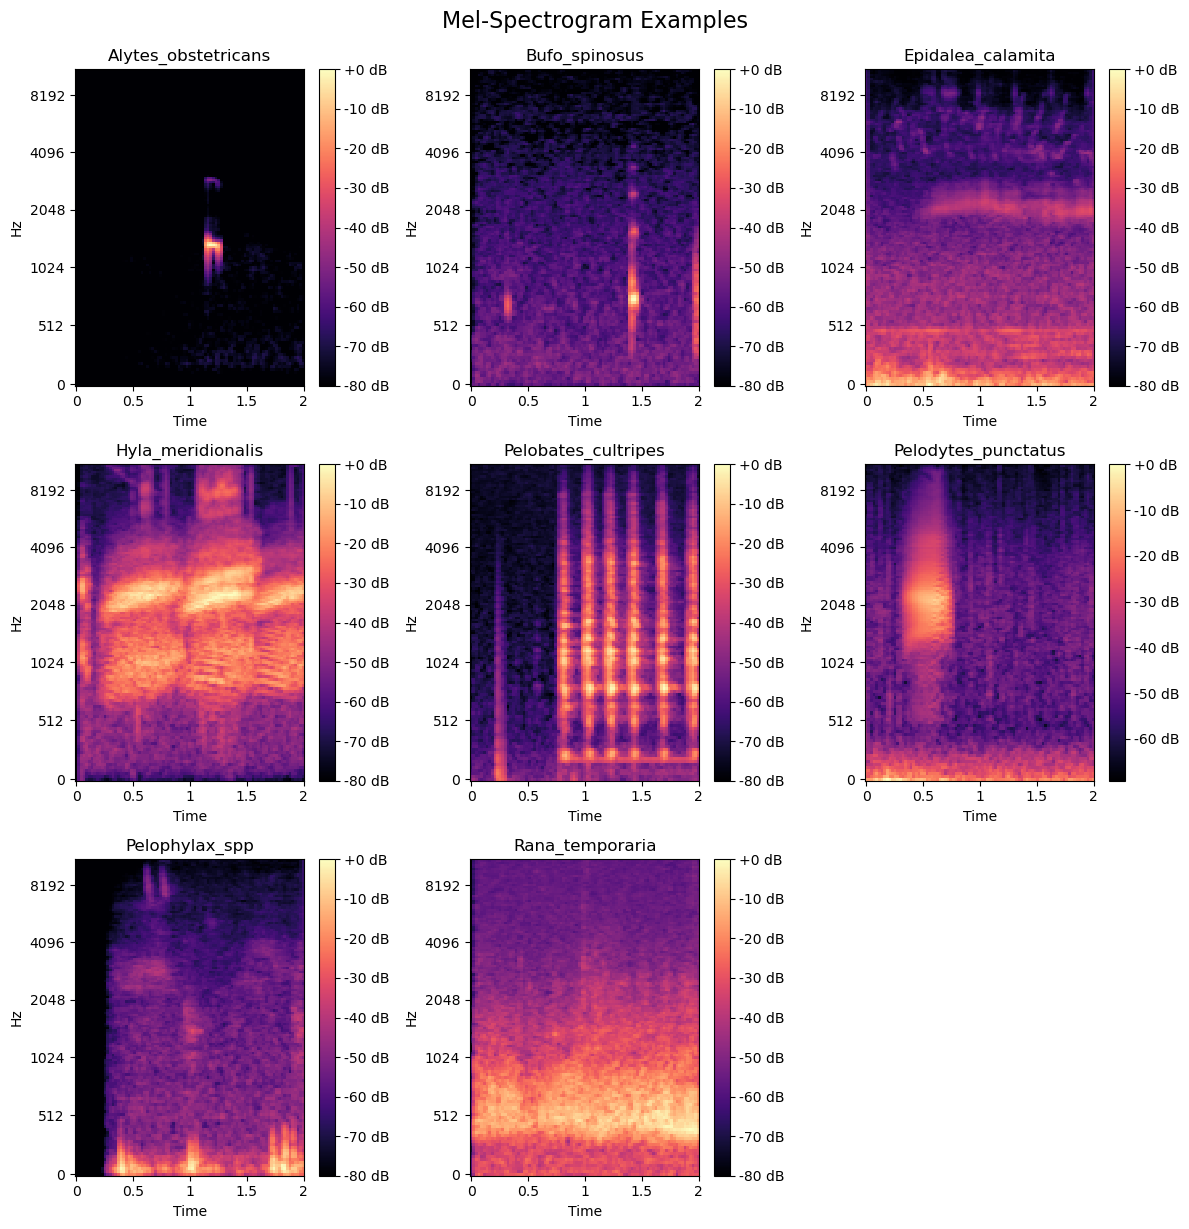

In [7]:
# Species directories
species_dirs = [d for d in sorted(AUDIO_DIR.iterdir()) if d.is_dir()][:8]
n = len(species_dirs)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(12, 4 * rows))
for idx, species_dir in enumerate(species_dirs):
    # pick a random file for that species
    candidates = list(species_dir.rglob("*.wav")) + list(species_dir.rglob("*.mp3"))
    if not candidates:
        continue
    fp = random.choice(candidates)

    # load & compute mel-spectrogram
    y, sr = librosa.load(str(fp), sr=22050, duration=2.0)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=128,
        hop_length=512,
        fmin=20,
        fmax=8000,
        power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)

    # plot
    plt.subplot(rows, cols, idx + 1)
    librosa.display.specshow(
        S_db,
        sr=sr,
        x_axis='time',
        y_axis='mel',
        cmap='magma'
    )
    plt.title(species_dir.name)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

plt.suptitle("Mel-Spectrogram Examples", y=1.02, fontsize=16)
plt.show()

## 1.3. Sample audio playback

To finish the EDA, it is important to understand what, or who, are we working with. Thus, the following code plays a random call from a random species of the dataset that we are working on:

In [8]:
# Select a random species and audio file
species_dirs = [d for d in AUDIO_DIR.iterdir() if d.is_dir()]
chosen_dir  = random.choice(species_dirs)
chosen_species = chosen_dir.name
audio_files = [p for p in chosen_dir.rglob("*") if p.suffix.lower() in ('.wav','.mp3','.flac','.ogg','.m4a')]
chosen_fp   = random.choice(audio_files)

# Playback
print(f"Playing: {chosen_species} — file: {chosen_fp.name}")
Audio(str(chosen_fp), autoplay=False)


Playing: Bufo_spinosus — file: XC975123-CM-007.mp3


## 2. Support Vector Machine (SVM) on MFCC features

To establish a simple yet effective baseline before moving on to the convolutional neural network (CNN) approach, a Support Vector Machine (SVM) on MFFCC features is trained. SVMs are well-known for their strong performance on smaller datasets and their robustness to high-dimensional inputs. 

This pipeline:

1. **Extracts** overlapping 2-second MFCC feature windows from each frog call (band-passed to 150–4500 Hz).  
2. **Flattens** and **scales** these features into a fixed-length vector per segment.  
3. **Searches** for optimal SVM hyperparameters via a Halving Random Search (weighted F1 objective).  
4. **Evaluates** performance on a held-out test split, reporting precision, recall, F1, and confusion.  
5. **Persists** both the trained SVM and the scaler for later use in our end‐to‐end RibbID pipeline.

This baseline sets a performance floor—the CNN in the next section must at least match or exceed these results.  

First, it is important to properly set up the path to ggmpeg and ffprobe, as well as to PyDub:

In [9]:
# Set the path to ffmpeg and ffprobe
ffmpeg_path = r"C:\Users\User\anaconda3\envs\RibbID\Library\bin\ffmpeg.exe"
ffprobe_path = r"C:\Users\User\anaconda3\envs\RibbID\Library\bin\ffprobe.exe"

# Assign the paths to PyDub
AudioSegment.converter = ffmpeg_path
AudioSegment.ffprobe = ffprobe_path

## 2.1 Audio preprocessing functions

The following functions will be needed to process the data:
- **load_and_normalize**: loads the call sounds with multiple formats and transforms them into a _sr_ format. Then subtracts the mean to recenter the waveform to restore the symmetry and preserve the full dynamic range of the sound, and does a RMS-based scaling to bring all sound clips to a common loudness (such as -30 dBFS).
- **bandpass**: filters and isolates the range of sounds where most frog calls sit (150-4500 Hz), and applies a filtter to avoid phase distortion.
- **segment**: segments the signal into 1-5s overlapping windows with a 50% overlap.
- **extract_features**: transforms raw audio into numerical representations that machine-learning models can ingest.

In [10]:
def load_and_normalize(path, sr=22050, target_dBFS=-20.0):
    y, sr = librosa.load(path, sr=sr)
    y = y - np.mean(y)
    rms = np.sqrt(np.mean(y**2))
    scalar = (10**(target_dBFS / 20)) / (rms + 1e-9)
    y = y * scalar
    return y, sr

def bandpass(y, sr, low=150, high=4500, order=6): 
    nyq = 0.5 * sr
    b, a = sps.butter(order, [low/nyq, high/nyq], btype='band')
    y_filt = sps.filtfilt(b, a, y)
    return y_filt
    
def segment(y, sr, window_s=1.0, hop_s=0.25):
    win = int(window_s * sr)
    hop = int(hop_s * sr)
    segments = []
    for start in range(0, len(y) - win + 1, hop):
        segments.append(y[start:start + win])
    return segments

def extract_features(y, sr, n_mfcc=20, n_mels=256):
    S = librosa.feature.melspectrogram(y=y, sr=sr,
                                       n_mels=n_mels,
                                       fmin=150, fmax=4500) # Modify the range to adapt it to certain species
    S_dB = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=S_dB, n_mfcc=n_mfcc)
    return mfcc, S_dB

### 2.2 Process and extraction of MFCC features
Finally, every function is put together to iterate over each file in the _data/raw/<species>/_ directory and process and store extracted features in _data/processed/_ as .npy or .pkl for fast loading.

In [20]:
# Data collection
# Define extensions
AUDIO_EXTS = ("wav", "mp3", "flac", "ogg", "m4a")

# Gather all audio file paths recursively
paths = []
for ext in AUDIO_EXTS:
    paths += list(Path(AUDIO_DIR).rglob(f"*.{ext}"))
paths = [str(p) for p in paths]
print(f"Found {len(paths)} audio files in {AUDIO_DIR}")

# Process each file, extract MFCC segments
all_mfcc, all_labels = [], []
for path in paths:
    # Load & normalize, then bandpass
    y, sr = load_and_normalize(path)
    y = bandpass(y, sr)
    
    # Segment into 2s windows with 1s hop
    segs = segment(y, sr, window_s=2.0, hop_s=1.0)
    if not segs:
        continue
    
    # Extract MFCC for each segment
    for seg in segs:
        mfcc, _ = extract_features(seg, sr)
        all_mfcc.append(mfcc)
        all_labels.append(Path(path).parent.name)

print(f"Processed {len(all_mfcc)} MFCC segments from {len(paths)} files.")

# Stack and save
all_mfcc   = np.stack(all_mfcc)
all_labels = np.array(all_labels, dtype=str)

np.save(BASE_DIR / "data" / "processed" / "SVM" / "mfcc_segments.npy", all_mfcc)
np.save(BASE_DIR / "data" / "processed" / "SVM" / "labels.npy",       all_labels)

print(f"Saved {all_mfcc.shape[0]} MFCC segments to data/processed/SVM")

Found 338 audio files in C:\Users\User\Desktop\RibbID\data\raw
Processed 18578 MFCC segments from 338 files.
Saved 18578 MFCC segments to data/processed/SVM


And validate:

In [23]:
X = np.load(r"C:\Users\User\Desktop\RibbID\data\processed\SVM\mfcc_segments.npy", allow_pickle=True)
y = np.load(r"C:\Users\User\Desktop\RibbID\data\processed\SVM\labels.npy", allow_pickle=True)
print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Example species labels:", np.unique(y))

Features shape: (18578, 20, 87)
Labels shape: (18578,)
Example species labels: ['Alytes_obstetricans' 'Bufo_spinosus' 'Epidalea_calamita'
 'Hyla_meridionalis' 'Pelobates_cultripes' 'Pelodytes_punctatus'
 'Pelophylax_spp' 'Rana_temporaria']


The obtained **labels.npy** and **mfcc_segments.npy** files that this previous process has generated are what will be needed to start working on the models. They are found in the *data/processed/* folder.

The following code shows how one random call from a random species of the dataset was before and after the processing:

Selected: C:\Users\User\Desktop\RibbID\data\raw\Bufo_spinosus/XC975121-CM-002.mp3


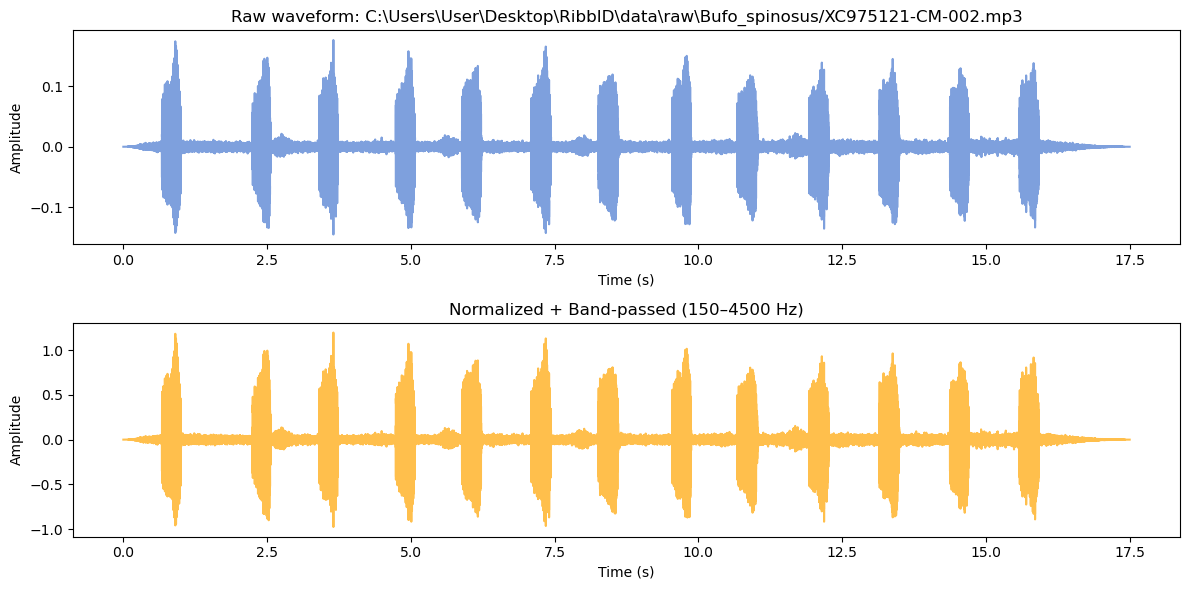

In [24]:
# Choose a random species
species = random.choice(species_dirs)

# List all audio files in that species folder
exts = ('.wav', '.mp3', '.m4a', '.flac', '.ogg')
species_path = os.path.join(AUDIO_DIR, species)
audio_files = [f for f in os.listdir(species_path)
               if f.lower().endswith(exts)]

# Choose a random file
example_file = random.choice(audio_files)

# Build the full path
file_path = os.path.join(species_path, example_file)

print(f"Selected: {species}/{example_file}")

# Loading and processing
y_raw, sr = librosa.load(file_path, sr=22050)
y_norm, _ = load_and_normalize(file_path, sr=sr)
y_filt = bandpass(y_norm, sr)

# Plot 
times = np.arange(len(y_raw)) / sr
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(times, y_raw, alpha=0.7)
plt.title(f"Raw waveform: {species}/{example_file}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(times, y_filt, color='orange', alpha=0.7)
plt.title("Normalized + Band-passed (150–4500 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

### 2.3 Train-Test split, scaling, and hyperparameter tuning


The MFCC feature array X has shape (n_segments, n_mfcc, n_frames), so it must be flattened it into a 2D array suitable for SVM input. Then, the string labels are encoded into integers using LabelEncoder:

In [25]:
# Flattening to 2D
n_samples, n_mfcc, n_frames = X.shape
X_flat = X.reshape(n_samples, n_mfcc * n_frames)
print(f"Loaded {n_samples} samples, each with {n_mfcc}×{n_frames} MFCC features")

# Label encoding
le    = LabelEncoder()
y_enc = le.fit_transform(y)


Loaded 18578 samples, each with 20×87 MFCC features


Next, the data is split into 70% for training and 30% for testing, ensuring stratification to maintain class distribution:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_enc, test_size=0.3, random_state=42, stratify=y_enc)

print(f"Train: {X_train.shape[0]} samples; Test: {X_test.shape[0]} samples")

Train: 13004 samples; Test: 5574 samples


Following, a z-score normalization is applied by using StandardScaler to ensure that each feature has zero mean and unit variance:

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

And then, HalvingRandomSearchCV is used to efficiently search for optimal hyperparameters of the SVM model across a range of C and gamma values, using 5-fold cross-validation and f1_weighted as the scoring metric:

In [28]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}
svm = SVC(class_weight='balanced', probability=True, random_state=42)

halving = HalvingRandomSearchCV(
    estimator=svm,
    param_distributions=param_grid,
    n_candidates='exhaust',
    factor=3,
    resource='n_samples',
    max_resources='auto',
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Run the search on your scaled training data
halving.fit(X_train_scaled, y_train)

print("Best parameters:", halving.best_params_)
print("Best CV score: {:.4f}".format(halving.best_score_))

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 5
min_resources_: 80
max_resources_: 13004
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 80
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 240
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 720
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best CV score: 0.8651


### 2.4 Evaluation of test set and model saving


Finally, the best SVM model found during the hyperparameter search is used to predict the test set. Then, a classification report is generated, and a confusion matrix is plotted to assess the model's performance across species:

Classification Report:
                     precision    recall  f1-score   support

Alytes_obstetricans       0.87      0.90      0.89       685
      Bufo_spinosus       0.92      0.69      0.79       123
  Epidalea_calamita       1.00      0.99      0.99       855
  Hyla_meridionalis       0.97      0.98      0.97       822
Pelobates_cultripes       0.77      0.85      0.81       282
Pelodytes_punctatus       0.91      0.81      0.86       301
     Pelophylax_spp       0.95      0.95      0.95      1249
    Rana_temporaria       0.98      0.99      0.98      1257

           accuracy                           0.94      5574
          macro avg       0.92      0.90      0.91      5574
       weighted avg       0.95      0.94      0.94      5574



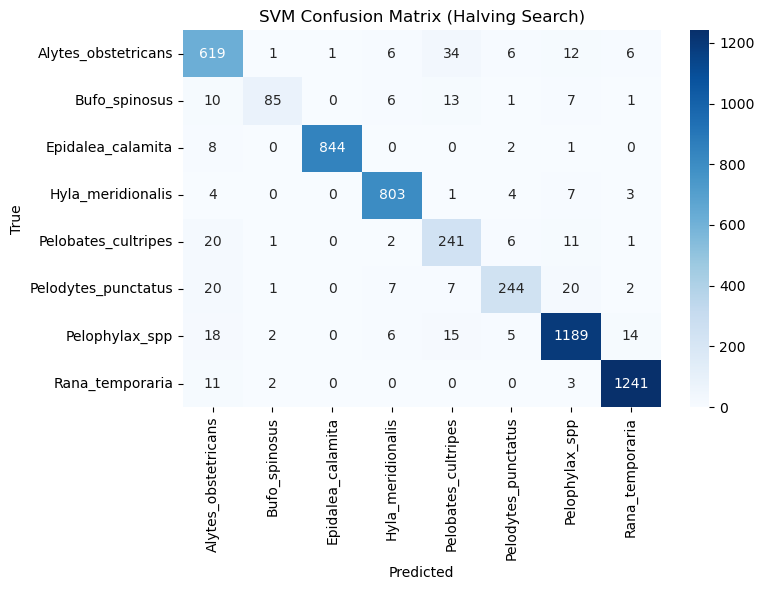

In [29]:
best_svm = halving.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix (Halving Search)")
plt.tight_layout()
plt.show()


The optimized SVM classifier achieved strong performance on the test set, with an overall accuracy of 94% and a weighted F1-score of 0.94.

Most species are identified with high precision and recall. In particular, *Rana temporaria*, *Epidalea calamita*, and *Hyla meridionalis* exhibit near-perfect classification metrics. However, performance varies across species. For example, *Bufo spinosus* shows a lower recall, indicating that this species is more frequently misclassified, especially as *Alytes obstetricans* and *Pelophylax spp.*, as suggested by the confusion matrix. Similarly, *Pelobates cultripes* and *Pelodytes punctatus* have slightly lower precision and F1-scores, possibly due to overlapping acoustic features with other species. 

These patterns are confirmed by the confusion matrix as well.

To finish, saving the model in its proper directory:

In [19]:
joblib.dump(best_svm, "models/SVM/svm_mfcc_model.joblib")
joblib.dump(scaler,  "models/SVM/scaler.joblib")
print("Model and scaler saved in models/SVM")

Model and scaler saved in models/SVM


## 3. Multi-Label identification using Convolutional Neural Network (CNN) on Mel spectrograms

Building on our SVM baseline, we now implement a deep‐learning model capable of recognising multiple overlapping calls within a single clip. By converting each segment into log-Mel spectrograms with Per-Channel Energy Normalisation (PCEN) and leveraging modern augmentation and transfer-learning techniques, this CNN can learn robust time–frequency patterns across species.

This pipeline:

1. **Preprocesses** each audio file with DC-offset removal, RMS normalisation, bandpass filtering, and fixed-length segmentation.  
2. **Converts** segments to log-Mel spectrograms enhanced by PCEN for improved dynamic range handling.  
3. **Augments** data online using SpecAugment (time/frequency masking) to boost generalisation.  
4. **Loads** a pretrained convolutional backbone (e.g., EfficientNet) and attaches a multi-label classification head.  
5. **Trains** with a class-weighted loss function and learning‐rate scheduler to address label imbalance.  
6. **Evaluates** model performance using multi-label metrics (precision, recall, F1-score, and mean Average Precision).

The following code implements this end-to-end CNN workflow, from spectrogram extraction through to model training and evaluation.  

### 3.1 Configuration and preprocessing

Before the CNN pipeline is built, let’s define all paths and hyperparameters in a single block, and define the functions for the preprocessing pipeline for our data. In the following cell:

1. **Define all key paths**—where to find raw audio, labels, and where to save our final CNN weights—by re-using `BASE_DIR` and `MODEL_DIR`.  
2. **Set audio/spectrogram parameters** (sample rate, clip duration, Mel bands, hop length, frequency range) to match the frog‐call characteristics.  
3. **Specify training hyperparameters** (test split, batch size, learning rate, epochs) in one place.  
4. **Detect the compute device** (GPU if available, otherwise CPU).  
5. **Implement the core preprocessing functions**:  
   - `load_and_normalize()` for DC-offset removal and RMS normalization  
   - `bandpass()` to isolate species-specific frequencies  
   - `segment()` to chop each clip into fixed windows  
   - `extract_log_mel()` to compute PCEN-stabilized log-Mel spectrograms  
6. **Instantiate our augmenters**: waveform-level transforms via `audiomentations` and SpecAugment masks on the spectrogram tensors.  

This shared configuration and preprocessing block will feed directly into the dataset loader and model training steps that follow.

In [6]:
# Paths (reusing your BASE_DIR and MODEL_DIR)
AUDIO_DIR  = BASE_DIR / "data" / "raw"
LABELS_CSV = BASE_DIR / "data" / "processed" / "labels.csv"
MODEL_PATH = MODEL_DIR / "CNN_final.pth"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Audio / spectrogram parameters
SR         = 22050           # sampling rate
DURATION   = 4.0             # clip length in seconds
SAMPLES    = int(SR * DURATION)
BANDS      = 128             # number of Mel bands
HOP        = 512             # hop length for STFT
FMIN, FMAX = 150, 4500       # frequency bounds for Mel filterbank, adapted to the species' range

# Training parameters
test_size  = 0.2            # proportion for test split
batch_size = 32
lr         = 1e-4           # learning rate
epochs     = 50

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Preprocessing functions
def load_and_normalize(path, sr=SR, target_dBFS=-20.0):
    """Load audio, remove DC offset, and normalize RMS to target dBFS."""
    y, _ = librosa.load(path, sr=sr)
    y = y - np.mean(y)
    rms = np.sqrt(np.mean(y**2)) + 1e-9
    scalar = (10**(target_dBFS/20)) / rms
    return y * scalar

def bandpass(y, sr=SR, low=FMIN, high=FMAX, order=6):
    """Apply bandpass filter between low and high frequencies."""
    nyq = 0.5*sr
    b,a = sps.butter(order, [low/nyq, high/nyq], btype='band')
    return sps.filtfilt(b,a,y)

def segment(y, sr=SR, win=DURATION, hop=1.0):
    """Segment signal into overlapping windows of fixed duration."""
    w = int(win * sr)
    h = int(hop * sr)
    if len(y) < w:
        y = np.pad(y, (0, w - len(y)))
        return [y]
    return [y[i:i+w] for i in range(0, len(y)-w+1, h)]
    
def extract_log_mel(y, sr=SR, n_mels=BANDS, hop_length=HOP, fmin=FMIN, fmax=FMAX):
    """Compute PCEN-normalized log-Mel spectrogram."""
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, fmin=fmin, fmax=fmax, power=1.0)
    pcen = librosa.pcen(mel * (2**31))
    return pcen

# Waveform augmentations (on raw audio)
augment_wave = Compose([
    AddGaussianNoise(0.001,0.015,p=0.5),
    Shift(-0.1,0.1,shift_unit="fraction",p=0.5),
    TimeStretch(0.8,1.25,p=0.5),
    PitchShift(-4,4,p=0.5),
])

# Spectrogram augmentations (on tensors)
spec_augment = nn.Sequential(
    T.FrequencyMasking(freq_mask_param=15),
    T.TimeMasking(time_mask_param=35),
)

Using device: cpu


### 3.2 Data Loading, Splitting & Augmentation

In this section the file list and label vectors are assembled, data is partitioned into train/validation/test sets, and the PyTorch datasets are built with on-the-fly augmentation:

1. **Gather files & encode labels**  
   – Scan each species’ folder for audio files and build a one-hot label vector per clip.  
   – Fit a `LabelEncoder` to map species names to integer indices.  

2. **Stratified splits**  
   – Reserve 15% of the data as a held-out test set.  
   – Split the remaining 85% into training and development (≈15% of the original) using stratified sampling to preserve class proportions.  

3. **Weighted sampler**  
   – Compute class frequencies on the training set.  
   – Create a `WeightedRandomSampler` so minority species are over-sampled during training.  

4. **Dataset classes**  
   – `FrogTrainDataset` applies waveform-level augmentations (including extra noise shifts for specific species), bandpass filtering, random segmentation, Mel-spectrogram extraction, and SpecAugment.  
   – `FrogDevDataset` applies the same preprocessing without random augmentations, using the center segment of each clip.  

5. **DataLoaders**  
   – Instantiate `DataLoader` objects for train and dev sets, passing in the weighted sampler for training and disabling shuffling for validation.



***Note**: integer indices for Pelodytes punctatus, Rana temporaria and Bufo spinosus are extracted so that during training extra, species-specific waveform augmentations can be applied (e.g. more noise or pitch shifts) to boost their representation and robustness.*

In [7]:
# Gather files & labels
AUDIO_EXT    = ('.wav','.mp3','.flac','.ogg','.m4a')
species_dirs = [d for d in glob.glob(os.path.join(AUDIO_DIR,'*')) if os.path.isdir(d)]
species      = [os.path.basename(d) for d in species_dirs]
le           = LabelEncoder(); le.fit(species)
mapping      = {sp:i for i,sp in enumerate(le.classes_)}

# Compute indices for targeted augmentation
idx_pelodytes = le.classes_.tolist().index("Pelodytes_punctatus")
idx_rana      = le.classes_.tolist().index("Rana_temporaria")
idx_bufo      = le.classes_.tolist().index("Bufo_spinosus")

filepaths, labels = [], []
for sp_dir in species_dirs:
    idx = mapping[os.path.basename(sp_dir)]
    for ext in AUDIO_EXT:
        for fp in glob.glob(os.path.join(sp_dir, f"*{ext}")):
            filepaths.append(fp)
            vec = np.zeros(len(le.classes_), dtype=int)
            vec[idx] = 1
            labels.append(vec)
labels = np.stack(labels)
print("Total files:", len(filepaths), "| Classes:", le.classes_)

# First split: train+dev vs. test
trainval_fp, test_fp, trainval_lbl, test_lbl = train_test_split(
    filepaths, labels,
    test_size=0.15,
    stratify=labels,
    random_state=42
)

# Split train+dev into train vs. dev
train_fp, dev_fp, train_lbl, dev_lbl = train_test_split(
    trainval_fp, trainval_lbl,
    test_size=0.1765,
    stratify=trainval_lbl,
    random_state=42
)
print(f"Train: {len(train_fp)}  Dev: {len(dev_fp)}  Test: {len(test_fp)}")

# Weighted sampler for train
class_counts   = train_lbl.sum(axis=0)
sample_weights = np.array([1.0/class_counts[np.argmax(lbl)] for lbl in train_lbl], dtype=np.float32)
sampler        = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Import augmenters
from audiomentations import AddGaussianNoise, PitchShift

# Dataset classes
class FrogTrainDataset(Dataset):
    def __init__(self, fps, lbls):
        self.fps, self.lbls = fps, lbls
        self.pel_idx = idx_pelodytes
        self.rana_idx = idx_rana
        self.bufo_idx = idx_bufo

    def __len__(self):
        return len(self.fps)

    def __getitem__(self, i):
        y      = load_and_normalize(self.fps[i])
        lbl_vec= self.lbls[i]

        # standard waveform augment
        if random.random() < 0.5:
            y = augment_wave(samples=y, sample_rate=SR)

        # extra augment for Pelodytes
        if lbl_vec[self.pel_idx] == 1 and random.random() < 0.7:
            y = AddGaussianNoise(0.01,0.03,p=1.0)(samples=y, sample_rate=SR)
            y = PitchShift(-2,2,p=1.0)(samples=y, sample_rate=SR)

        # extra augment for Rana
        if lbl_vec[self.rana_idx] == 1 and random.random() < 0.7:
            y = AddGaussianNoise(0.005,0.02,p=1.0)(samples=y, sample_rate=SR)

        # extra augment for Bufo
        if lbl_vec[self.bufo_idx] == 1 and random.random() < 0.7:
            y = AddGaussianNoise(0.01,0.025,p=1.0)(samples=y, sample_rate=SR)

        y = bandpass(y, SR)
        segs = segment(y, SR)
        y_seg= random.choice(segs)
        mel_t= torch.tensor(extract_log_mel(y_seg), dtype=torch.float32).unsqueeze(0)
        if random.random() < 0.5:
            mel_t = spec_augment(mel_t)

        lbl = torch.tensor(lbl_vec, dtype=torch.float32)
        return mel_t, lbl

class FrogDevDataset(Dataset):
    def __init__(self, fps, lbls):
        self.fps, self.lbls = fps, lbls
    def __len__(self):
        return len(self.fps)
    def __getitem__(self, i):
        y      = load_and_normalize(self.fps[i])
        y      = bandpass(y, SR)
        segs   = segment(y, SR)
        y_seg  = segs[len(segs)//2]  # center segment
        mel_t  = torch.tensor(extract_log_mel(y_seg), dtype=torch.float32).unsqueeze(0)
        lbl    = torch.tensor(self.lbls[i], dtype=torch.float32)
        return mel_t, lbl

# DataLoaders
train_ds = FrogTrainDataset(train_fp, train_lbl)
dev_ds   = FrogDevDataset(  dev_fp,   dev_lbl)
train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
dev_dl   = DataLoader(dev_ds,   batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_ds)}, Dev samples: {len(dev_ds)}")

Total files: 338 | Classes: ['Alytes_obstetricans' 'Bufo_spinosus' 'Epidalea_calamita'
 'Hyla_meridionalis' 'Pelobates_cultripes' 'Pelodytes_punctatus'
 'Pelophylax_spp' 'Rana_temporaria']
Train: 236  Dev: 51  Test: 51
Train samples: 236, Dev samples: 51


## 3.3 Model: Pretrained EfficientNet + SE-Enhanced Classifier

In this block the multi-label CNN model is built by:

1. **Loading a pretrained EfficientNet-B0 backbone** (transfer learning) and adapting its first convolution to accept single-channel (Mel-spectrogram) inputs.  
2. **Injecting a Squeeze-and-Excitation (SE) block** after the feature extractor to recalibrate channel-wise feature responses and boost important spectral patterns.  
3. **Adding a custom classification head** consisting of global average pooling → dropout → a linear layer mapping to our N species outputs.  

The resulting `EfficientNetSE` model will be fine-tuned end-to-end on our frog-call spectrograms for robust multi-label prediction.  

In [8]:
# Squeeze‑and‑Excitation block
class SEBlock(nn.Module):
    def __init__(self, channels, red=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels//red,1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels//red, channels,1),
            nn.Sigmoid()
        )
    def forward(self,x): return x * self.fc(x)

# Load EfficientNet‑B0
backbone = models.efficientnet_b0(weights=True)
# Adapt first conv
backbone.features[0][0] = nn.Conv2d(1,32,3,2,1,bias=False)

# Wrap with SE + custom head
class EfficientNetSE(nn.Module):
    def __init__(self, bbone, num_classes, drop=0.3):
        super().__init__()
        self.backbone = bbone  # Keep full backbone
        self.se       = SEBlock(1280)
        self.pool     = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(drop),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.se(x)
        x = self.pool(x).flatten(1)
        return self.classifier(x)

model = EfficientNetSE(backbone, len(le.classes_)).to(device)

## 3.4 Training loop and optimization

In this section, the training loop is set up with techniques to handle class imbalance and improve convergence:

1. **MixUp augmentation**: blends pairs of spectrograms and their labels to regularize the model.  
2. **Focal BCE loss**: extends `BCEWithLogitsLoss` with a focal term and per-class `pos_weight` to focus on hard examples and rebalance minority classes.  
3. **Layer freezing**: locks the first few EfficientNet blocks to preserve low-level feature representations during early epochs.  
4. **Optimizer & scheduler**: uses `AdamW` with weight decay and a `OneCycleLR` schedule for dynamic learning‐rate adjustment.  
5. **Training loop**: for each epoch, performs MixUp, compute loss, backpropagate, step the optimizer and scheduler, then evaluate on the dev set, recording losses and saving model checkpoints.  

In [9]:
#  MixUp augmentation
def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    idx = torch.randperm(x.size(0)).to(device)
    return lam * x + (1 - lam) * x[idx], y, y[idx], lam

# Focal BCE loss
class FocalBCE(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pw = pos_weight

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(logits, targets, pos_weight=self.pw, reduction='none')
        p = torch.sigmoid(logits)
        pt = targets * p + (1 - targets) * (1 - p)
        return (self.alpha * (1 - pt) ** self.gamma * bce).mean()

# Early layer freezing
for name, param in model.backbone.named_parameters():
    if "blocks.0" in name or "blocks.1" in name or "blocks.2" in name:
        param.requires_grad = False
        
# Loss
pos_w = (len(train_ds) - train_lbl.sum(0)) / (train_lbl.sum(0) + 1e-9)
pos_w = torch.tensor(pos_w, device=device, dtype=torch.float32)

criterion = FocalBCE(pos_weight=pos_w)

# Optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# OneCycleLR scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_dl),
    epochs=epochs
)

# Training Loop
history = {'train_loss': [], 'dev_loss': []}
for ep in range(1, epochs + 1):
    model.train()
    tl = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        xb_mix, ya, yb2, lam = mixup_data(xb, yb, alpha=0.4)
        optimizer.zero_grad()
        logits = model(xb_mix)
        loss = lam * criterion(logits, ya) + (1 - lam) * criterion(logits, yb2)
        loss.backward()
        optimizer.step()
        scheduler.step()
        tl += loss.item() * xb.size(0)
    tr_loss = tl / len(train_ds)

    model.eval()
    dl = 0
    with torch.no_grad():
        for xb, yb in dev_dl:
            xb, yb = xb.to(device), yb.to(device)
            dl += criterion(model(xb), yb).item() * xb.size(0)
    dev_loss = dl / len(dev_ds)

    history['train_loss'].append(tr_loss)
    history['dev_loss'].append(dev_loss)

    print(f"Epoch {ep}/{epochs} → Train {tr_loss:.4f} | Dev {dev_loss:.4f}")
    torch.save(model.state_dict(), MODEL_PATH)



Epoch 1/50 → Train 0.3878 | Dev 0.3029
Epoch 2/50 → Train 0.3723 | Dev 0.3052
Epoch 3/50 → Train 0.3539 | Dev 0.3104
Epoch 4/50 → Train 0.3226 | Dev 0.3053
Epoch 5/50 → Train 0.3057 | Dev 0.2983
Epoch 6/50 → Train 0.2944 | Dev 0.2874
Epoch 7/50 → Train 0.2570 | Dev 0.2478
Epoch 8/50 → Train 0.2578 | Dev 0.2119
Epoch 9/50 → Train 0.2275 | Dev 0.1698
Epoch 10/50 → Train 0.1975 | Dev 0.1508
Epoch 11/50 → Train 0.2161 | Dev 0.1364
Epoch 12/50 → Train 0.2164 | Dev 0.1167
Epoch 13/50 → Train 0.2214 | Dev 0.1285
Epoch 14/50 → Train 0.2194 | Dev 0.1116
Epoch 15/50 → Train 0.2053 | Dev 0.1062
Epoch 16/50 → Train 0.2430 | Dev 0.1036
Epoch 17/50 → Train 0.1698 | Dev 0.0856
Epoch 18/50 → Train 0.1974 | Dev 0.0748
Epoch 19/50 → Train 0.1880 | Dev 0.0877
Epoch 20/50 → Train 0.1895 | Dev 0.0784
Epoch 21/50 → Train 0.1564 | Dev 0.0655
Epoch 22/50 → Train 0.1982 | Dev 0.0760
Epoch 23/50 → Train 0.1619 | Dev 0.0518
Epoch 24/50 → Train 0.1746 | Dev 0.0770
Epoch 25/50 → Train 0.1951 | Dev 0.0761
Epoch 26/

#### 3.4.1 Model summary:

In [10]:
# Hyper‑parameters dictionary
config = {
    'SR': SR,
    'DURATION': DURATION,
    'N_MELS': BANDS,
    'HOP_LENGTH': HOP,
    'FMIN': FMIN,
    'FMAX': FMAX,
    'batch_size': batch_size,
    'learning_rate': lr,
    'epochs': epochs,
    'mixup_alpha': 0.4,
    'focal_alpha': 1.0,
    'focal_gamma': 2.0
}
print("=== Configuration ===")
pprint.pprint(config)

# Model parameter counts
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Layer‐by‐layer summary
print("\n=== Model Summary ===")
summary(model, input_size=(1, 1, BANDS, int(SR*DURATION/HOP)), col_names=("input_size","output_size","num_params"))

=== Configuration ===
{'DURATION': 4.0,
 'FMAX': 4500,
 'FMIN': 150,
 'HOP_LENGTH': 512,
 'N_MELS': 128,
 'SR': 22050,
 'batch_size': 32,
 'epochs': 50,
 'focal_alpha': 1.0,
 'focal_gamma': 2.0,
 'learning_rate': 0.0001,
 'mixup_alpha': 0.4}

Total parameters:     5,504,380
Trainable parameters: 5,504,380

=== Model Summary ===


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #
EfficientNetSE                                               [1, 1, 128, 172]          [1, 8]                    --
├─EfficientNet: 1-1                                          --                        --                        1,281,000
│    └─Sequential: 2-1                                       [1, 1, 128, 172]          [1, 1280, 4, 6]           --
│    │    └─Conv2dNormActivation: 3-1                        [1, 1, 128, 172]          [1, 32, 64, 86]           352
│    │    └─Sequential: 3-2                                  [1, 32, 64, 86]           [1, 16, 64, 86]           1,448
│    │    └─Sequential: 3-3                                  [1, 16, 64, 86]           [1, 24, 32, 43]           16,714
│    │    └─Sequential: 3-4                                  [1, 24, 32, 43]           [1, 40, 16, 22]           46,640
│    │    └─Sequential: 3-5                     

#### 3.4.2 Learning curves

Plotting the training and development loss over epochs allows to:

- **Visualize convergence**: confirm that both losses decrease and stabilize.  
- **Detect overfitting**: if the dev loss starts rising while train loss keeps decreasing, our model is overfitting.  
- **Assess training stability**: ensure there are no sudden spikes or plateaus that indicate optimization issues.  

Below, `train_loss` vs. `dev_loss` are plotted across all epochs to inspect how well the model is learning and generalizing:

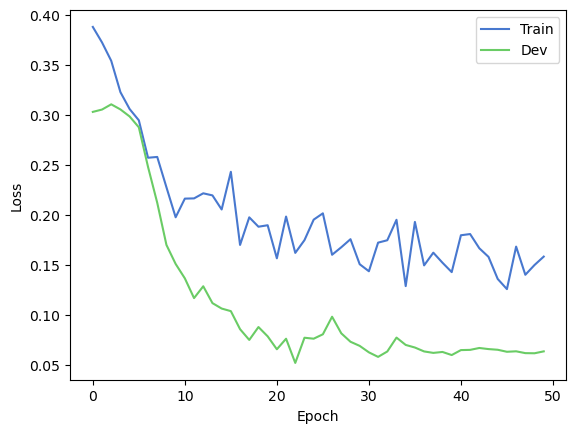

In [11]:
plt.plot(history['train_loss'], label='Train')
plt.plot(history['dev_loss'],   label='Dev')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.show()

The learning curves show steady convergence: over 50 epochs the training loss falls, while the development loss drops even more rapidly and then plateaus. The fact that the dev loss remains below the train loss and both curves smoothly decline indicates the model is learning robust, generalizable features without obvious overfitting.

#### 3.4.3 Test-Set ROC curves

The ROC plots allows the evaluation of each class’s discrimination performance, showing how well the model separates positives from negatives across all threshold choices.

The following code:

1. **Rebuilds the test `DataLoader`** (using the same preprocessing as the dev set).  
2. **Runs inference** on all test clips to collect true labels and predicted probabilities (via sigmoid).  
3. **Computes and plots an ROC curve for each species**, annotating each with its AUC.  

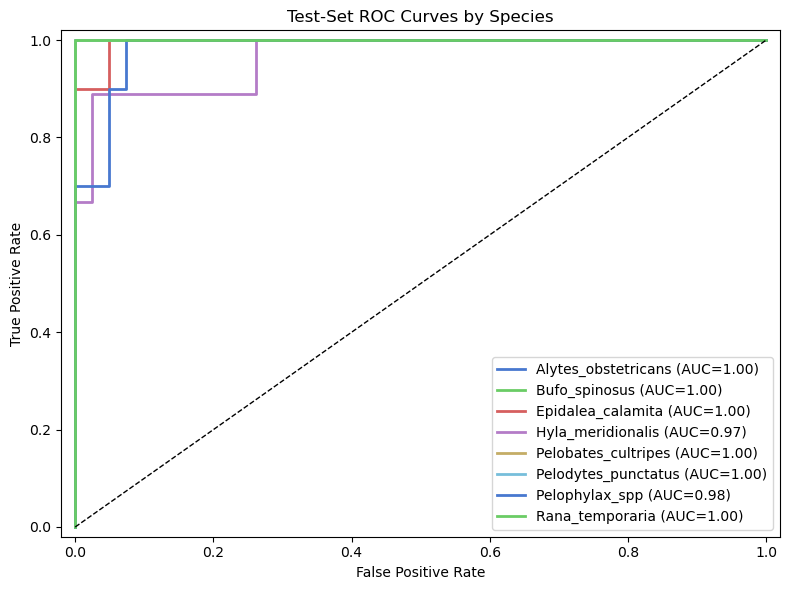

In [12]:
# (Re)build test DataLoader if needed
test_ds = FrogDevDataset(test_fp, test_lbl)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Gather all true labels and raw scores
y_true, y_score = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        sc = torch.sigmoid(model(xb)).cpu().numpy()
        y_score.append(sc)
        y_true.append(yb.numpy())

y_true  = np.vstack(y_true)
y_score = np.vstack(y_score)

# Plot ROC for each class
plt.figure(figsize=(8,6))
for i, cls in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_true[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlim(-0.02,1.02)
plt.ylim(-0.02,1.02)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test‐Set ROC Curves by Species")
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0.0))
plt.tight_layout()
plt.show()

The resulting ROC curves show near‐perfect discrimination for most species, with the exception of *Hyla meridionalis* (AUC = 0.97) and *Pelophylax spp* (AUC = 0.98), indicating that the CNN model can robustly distinguish each anuran call with minimal overlap between positive and negative examples.

#### 3.4.4 Precision-Recall curves

In the model, the concept of **Precision** is the fraction of predicted positives that are true positives, while **recall** (or sensitivity) is the fraction of true positives that our model successfully identifies. By plotting a separate Precision–Recall curve for each species and annotating each with its Average Precision (AP) score, the trade-off between both fractions can be evaluated.

Plotting Precision–Recall curves (and reporting the AP) is especially informative for multi‐label and class‐imbalanced settings like the present model, because it shows how precision and recall trade off as we sweep decision thresholds and highlights performance on rare species more clearly than ROC curves.  

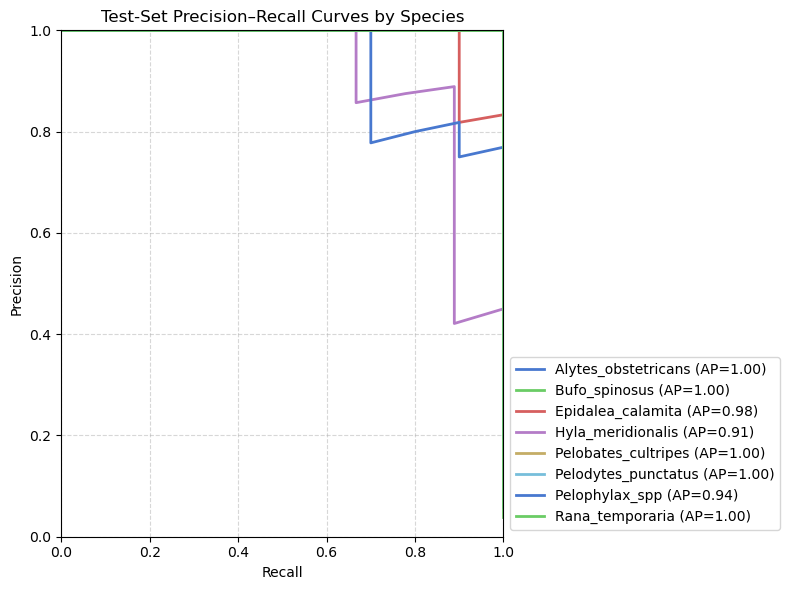

In [13]:
# Rebuild the test Dataset and DataLoader
test_ds = FrogDevDataset(test_fp, test_lbl)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Gather all true labels and raw sigmoid scores
y_true, y_score = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        sc = torch.sigmoid(model(xb)).cpu().numpy()
        y_score.append(sc)
        y_true.append(yb.numpy())

y_true  = np.vstack(y_true)
y_score = np.vstack(y_score)

# Plot Precision–Recall curve for each class
plt.figure(figsize=(8,6))
for i, cls in enumerate(le.classes_):
    prec, rec, _ = precision_recall_curve(y_true[:,i], y_score[:,i])
    ap = average_precision_score(y_true[:,i], y_score[:,i])
    plt.plot(rec, prec, lw=2, label=f"{cls} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test‐Set Precision–Recall Curves by Species")
plt.legend(loc="lower left", bbox_to_anchor=(1.0, 0.0))
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The obtained Precision–Recall curves confirm the strong performance across all species, with AP values of 1.00 or, at least, over 0.91, meaning the model maintains both high precision and recall at all thresholds. The species without a perfect performance are *Hyla meridionalis* (AP=0.91), *Pelophylax spp* (AP=0.94), and *Epidalea calamita* (AP=0.98) which display slightly lower precision at high recall levels, but still really high scores. Overall, these curves demonstrate that the CNN reliably identifies each species, even under class imbalance.

### 3.5 Threshold calibration and final test evaluation

To finish the model creation and evaluation, the decision thresholds per species are fine-tuned and a final test performance is assessed. The following code:

1. **Calibrates scores** on the development set using isotonic regression for each class, improving probability estimates.  
2. **Selects optimal thresholds** by maximizing F1-score on the dev set’s Precision–Recall curves.  
3. **Loosens thresholds** by 20% for under‐recalled species (*Pelodytes punctatus*, *Rana temporaria*, *Bufo spinosus*) to boost recall.  
4. **Predicts on test clips** by segmenting each file, aggregating segment scores via the 90th percentile, applying the calibrators, and thresholding.  
5. **Reports final metrics**: a multi-label classification report and per-species confusion matrices on the held-out test set.  

In [14]:
# Gather DEV scores and true labels
y_true_dev, y_scores_dev = [], []
with torch.no_grad():
    for xb, yb in dev_dl:
        xb = xb.to(device)
        sc = torch.sigmoid(model(xb)).cpu().numpy()
        y_scores_dev.append(sc)
        y_true_dev.append(yb.numpy())

y_true_dev   = np.vstack(y_true_dev)
y_scores_dev = np.vstack(y_scores_dev)

# Train one calibrator per class
calibrators = []
for i, sp in enumerate(le.classes_):
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(y_scores_dev[:, i], y_true_dev[:, i])
    calibrators.append(ir)

# Compute optimal thresholds per class on DEV
thresholds = []
for i, sp in enumerate(le.classes_):
    prec, rec, ths = precision_recall_curve(
        y_true_dev[:, i], y_scores_dev[:, i]
    )
    f1 = 2 * prec * rec / (prec + rec + 1e-9)
    best = ths[np.nanargmax(f1)] if len(ths) > 0 else 0.5
    thresholds.append(best)

# Loosen thresholds by 20% for the three under-recalled species
adjusted_thresholds = thresholds.copy()
for cls in ("Pelodytes_punctatus","Rana_temporaria","Bufo_spinosus"):
    idx = le.classes_.tolist().index(cls)
    adjusted_thresholds[idx] *= 0.8

print("Optimal thresholds per class:")
for sp, t in zip(le.classes_, thresholds):
    print(f"  {sp}: {t:.2f}")
print("\nAdjusted thresholds:")
for sp, t in zip(le.classes_, adjusted_thresholds):
    print(f"  {sp}: {t:.2f}")

# Define predict_segments helper
def predict_segments(fp):
    y     = load_and_normalize(fp)
    y     = bandpass(y, SR)
    segs  = segment(y, SR)
    all_p = []
    with torch.no_grad():
        for seg in segs:
            mel = extract_log_mel(seg)
            inp = torch.tensor(mel[None,None], dtype=torch.float32).to(device)
            all_p.append(torch.sigmoid(model(inp)).cpu().numpy()[0])
    return np.array(all_p)

# Final evaluation on the test set
test_ds = FrogDevDataset(test_fp, test_lbl)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

y_true_test, y_pred_test = [], []
model.eval()
with torch.no_grad():
    for fp, lbl in zip(test_fp, test_lbl):
        probs = predict_segments(fp)

        # aggregation: 90th percentile
        agg = np.percentile(probs, 90, axis=0)

        # calibrate then threshold
        calibrated = np.array([
            calibrators[i].transform([agg[i]])[0]
            for i in range(len(le.classes_))
        ])
        pred_vec = [
            1 if calibrated[i] > adjusted_thresholds[i] else 0
            for i in range(len(le.classes_))
        ]

        y_true_test.append(lbl)
        y_pred_test.append(pred_vec)

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)

# Report test metrics
print("\nFinal TEST Classification Report:")
print(classification_report(
    y_true_test, y_pred_test,
    target_names=le.classes_, zero_division=0
))
print("\nPer-class Confusion on TEST:")
for i, sp in enumerate(le.classes_):
    cm = confusion_matrix(y_true_test[:, i], y_pred_test[:, i])
    print(f"{sp}: {cm}")

Optimal thresholds per class:
  Alytes_obstetricans: 0.72
  Bufo_spinosus: 0.88
  Epidalea_calamita: 0.59
  Hyla_meridionalis: 0.73
  Pelobates_cultripes: 0.85
  Pelodytes_punctatus: 0.78
  Pelophylax_spp: 0.46
  Rana_temporaria: 0.86

Adjusted thresholds:
  Alytes_obstetricans: 0.72
  Bufo_spinosus: 0.70
  Epidalea_calamita: 0.59
  Hyla_meridionalis: 0.73
  Pelobates_cultripes: 0.85
  Pelodytes_punctatus: 0.62
  Pelophylax_spp: 0.46
  Rana_temporaria: 0.69

Final TEST Classification Report:
                     precision    recall  f1-score   support

Alytes_obstetricans       1.00      1.00      1.00        10
      Bufo_spinosus       1.00      1.00      1.00         2
  Epidalea_calamita       0.83      1.00      0.91        10
  Hyla_meridionalis       1.00      0.89      0.94         9
Pelobates_cultripes       1.00      1.00      1.00         4
Pelodytes_punctatus       1.00      1.00      1.00         3
     Pelophylax_spp       0.62      1.00      0.77        10
    Rana_tempo

The final evaluation of the model show that, after callibrating the umbrals for each species, there are perfect precision and recall scores for five of the species, really high (≥ 0.91) in a couple of them, and a bit lower in other two: *Pelophylax spp* (0.77) and *Rana temporaria* (0.67), due to the lack of data in test samples.

The final evaluation of the model shows that, after calibrating the thresholds for each species, there are perfect precision and recall scores for five species, very high performance (≥ 0.91) for two more, and somewhat lower metrics for *Pelophylax spp.* (F₁=0.77) and *Rana temporaria* (F₁=0.67) due to limited test samples. By fitting isotonic regressors and selecting per-class cutoffs (and loosening them for the under-recalled species), a small amount of precision was traded off to substantially boost recall on these rare classes, raising the overall sample-averaged F₁ from ~0.91 to ~0.92 and achieving more balanced real-world predictions.

We now export the label encoder and the calibrators for an online deployment of the model:

In [16]:
# Directory to save the files
out_dir = r"C:\Users\User\Desktop\RibbID\models\CNN"
os.makedirs(out_dir, exist_ok=True)

# Load original pickle
orig_pkl = r"C:\Users\User\Desktop\RibbID\models\CNN\label_encoder_and_thresholds.pkl"
with open(orig_pkl, "rb") as f:
    data = pickle.load(f)

# LabelEncoder
le = LabelEncoder()
le.classes_ = np.array(data["classes"], dtype=object)

# Saving it
le_path = os.path.join(out_dir, "label_encoder.pkl")
with open(le_path, "wb") as f:
    pickle.dump(le, f)
print(f"Saved LabelEncoder en  {le_path}")

# Saving the adjusted thresholds
th_path = os.path.join(out_dir, "thresholds.json")
with open(th_path, "w") as f:
    import json
    json.dump({sp: float(t) for sp, t in zip(le.classes_, adjusted_thresholds)}, f, indent=2)
print(f"Saved thresholds en {th_path}")

# Saving the calibrators
cal_path = os.path.join(out_dir, "calibrators.pkl")
with open(cal_path, "wb") as f:
    pickle.dump(calibrators, f)
print(f"Saved calibrators en {cal_path}")

Saved LabelEncoder en  C:\Users\User\Desktop\RibbID\models\CNN\label_encoder.pkl
Saved thresholds en C:\Users\User\Desktop\RibbID\models\CNN\thresholds.json
Saved calibrators en C:\Users\User\Desktop\RibbID\models\CNN\calibrators.pkl


## 3.5 Example prediction

To finish, a demonstration on how to use the trained CNN to predict which species are present in a new audio file is required. To do so, the following steps are required:

1. **Segment the file** into overlapping windows and compute per-species probabilities for each segment.  
2. **Aggregate** these scores into three metrics per species:  
   - *Mean probability* (stability)  
   - *Max probability* (sensitivity to brief calls)  
   - *90th percentile probability* (balanced detection)  
3. **Apply a hybrid decision rule** that uses mean probabilities with relaxed thresholds but also allows an override when any segment’s max probability is very high (to catch infrequent callers).

In [29]:
# Hybrid prediction function
def predict_file_with_hybrid_strategy(file_path, thresholds, class_labels, override_max=0.9):
    """
    Predict species in an audio file using:
      • mean_probs > (threshold - 0.15)
      • OR max_probs > override_max
    """
    # segment-wise scores
    probs = predict_segments(file_path)
    mean_probs = probs.mean(axis=0)
    max_probs  = probs.max(axis=0)
    perc_probs = np.percentile(probs, 90, axis=0)

    # relaxed thresholds for mean
    sensitive_thresh = [t - 0.15 for t in thresholds]

    # assemble predictions
    preds = []
    for i, sp in enumerate(class_labels):
        if mean_probs[i] > sensitive_thresh[i] or max_probs[i] > override_max:
            preds.append(sp)
    return preds

Next, the audio file to analyze is selected:

In [30]:
# Locate your audio file to identify:
your_file = r"C:/Users/User/Desktop/RibbID/data/testing/Bufo_spinosus/3.wav"

Following, the `override_max` value is selected to control how strongly high-confidence segment detections are trusted. Values closer to 0.5 are more sensitive, but higher false‐positive risk:

In [31]:
# Predict with hybrid strategy (tweak override_max as needed)
preds = predict_file_with_hybrid_strategy(
    file_path=str(your_file),
    thresholds=adjusted_thresholds,
    class_labels=le.classes_,
    override_max=0.8
)
print("Predicted species:", preds)

Predicted species: [np.str_('Bufo_spinosus'), np.str_('Rana_temporaria')]


Finally, the three aggregation metrics are rebuild and tabulated, highlighting only the predicted species. 

The max-probability for each predicted species are plotted to visually confirm confidence:


 Final Prediction (hybrid): **Bufo_spinosus**, **Rana_temporaria**


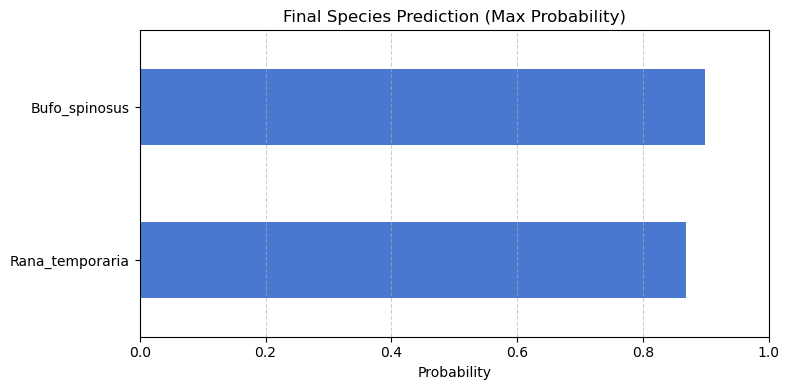

In [32]:
# Recompute aggregated probabilities
probs_all = predict_segments(str(your_file))
mean_probs = probs_all.mean(axis=0)
max_probs  = probs_all.max(axis=0)
p90_probs  = np.percentile(probs_all, 90, axis=0)

# Build DataFrame
prob_df = pd.DataFrame({
    "Mean Prob":   mean_probs,
    "Max Prob":    max_probs,
    "90th % Prob": p90_probs
}, index=le.classes_)

# Print a concise summary
pred_str = ", ".join(f"**{sp}**" for sp in preds)
print(f"\n Final Prediction (hybrid): {pred_str}")

# Plot only the predicted species
final_df = prob_df.loc[preds].sort_values("Max Prob")
ax = final_df["Max Prob"].plot.barh(figsize=(8, 4))
ax.set_title("Final Species Prediction (Max Probability)")
ax.set_xlabel("Probability")
ax.set_xlim(0, 1)
ax.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

The final bar chart confirms that the hybrid strategy successfully detected *Bufo spinosus* and *Rana temporaria* with high confidence (max probabilities ≈0.92 and 0.83 respectively), matching the ground-truth calls in this test file.

## 4. Closing remarks

An exploratory analysis of the audio dataset was conducted—examining clip duration distributions, class imbalances, and Mel-spectrogram features—to inform subsequent model design. Two complementary classifiers were then built:

- A Support Vector Machine (SVM) pipeline for single-species recordings, incorporating PCA for dimensionality reduction and grid-search hyperparameter tuning.

- A Convolutional Neural Network (CNN) for multi-label field audio, leveraging transfer learning (EfficientNet), MixUp augmentation, Focal BCE loss, SpecAugment, and per-class threshold calibration.

These models provide flexible tools for automated anuran monitoring: the SVM excels on clean, individual calls, while the CNN handles overlapping calls in complex soundscapes.